In [1]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/artyomkolas/3-kinds-of-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yahyahamza
Your Kaggle Key: ··········


100%|██████████| 3.49G/3.49G [00:32<00:00, 114MB/s]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import glob as gb
import cv2
from tensorflow import keras
import plotly.express as px
import scipy as sp
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img
import random
import tensorflow as tf

In [4]:
data = '/content/3-kinds-of-pneumonia/Curated X-Ray Dataset'
COVID = '/content/3-kinds-of-pneumonia/Curated X-Ray Dataset/COVID-19'
Normal = '/content/3-kinds-of-pneumonia/Curated X-Ray Dataset/Normal'
Bacterial = '/content/3-kinds-of-pneumonia/Curated X-Ray Dataset/Pneumonia-Bacterial'
Viral = '/content/3-kinds-of-pneumonia/Curated X-Ray Dataset/Pneumonia-Viral'

In [5]:
DATADIR = data
CATEGORIES=[Normal,COVID, Bacterial,Viral]
img_size = 224
training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num= CATEGORIES.index (category) 
        for img in tqdm (os.listdir (path)):
             try:
                    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR) 
                    new_array = cv2.resize(img_array, (img_size, img_size)) 
                    training_data.append( [new_array, class_num])
             except Exception as e:
                pass
                    
create_training_data()

100%|██████████| 1656/1656 [00:24<00:00, 66.76it/s]


In [6]:
x=[]
y=[]
for features,label in training_data:
    x.append(features)
    y.append(label)
x=np.array(x).reshape(-1,img_size,img_size, 3)#(number of photos,224,224,3)
y=np.array(y)

In [7]:
x.shape , x[1].shape

((9208, 224, 224, 3), (224, 224, 3))

In [8]:
dic = {
    0 : 'Normal',
    1 : 'COVID-19',
    2 : 'Pneumonia-Bacterial',
    3 : 'Pneumonia-Viral',
}
def getDiseaseName(code):
    for x,y in dic.items():
        if code==x:
            return y

In [9]:
# To divide data to train and test and shuffle the
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [10]:
print(f'X_train shape  is {x_train.shape}')
print(f'X_test shape  is {x_test.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')

X_train shape  is (7826, 224, 224, 3)
X_test shape  is (1382, 224, 224, 3)
y_train shape  is (7826,)
y_test shape  is (1382,)


In [11]:
# Hyperparameters
IMG_IND = 224
IMG_SHAPE =(IMG_IND,IMG_IND,3)
IMG_SIZE = (224,224)
SEED = 2
BATCH_SIZE = 16

In [12]:
# DenseNet Dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, VGG16, ResNet50
from keras import backend as K
from tensorflow.keras import Sequential
import keras 
import matplotlib
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

In [13]:
def get_callbacks(model_name):
    callbacks =[]
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss',mode='min',save_best_only=True)
    callbacks.append(checkpoint)
    anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto') 
    callbacks.append(anne)
    return callbacks

In [14]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile( loss='sparse_categorical_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy' ]
)

94668760/94668760 [==============================] - 1s 0us/step


In [15]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
callbacks = get_callbacks('ResNet50V2')
training_history = model.fit(x_train, y_train, validation_split=0.15, epochs=20, batch_size=64 ,callbacks=[callbacks])

Epoch 1/20
104/104 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.8023
Epoch 1: val_loss improved from inf to 3.19595, saving model to model.ResNet50V2.h5
104/104 [==============================] - 111s 619ms/step - loss: 0.4884 - accuracy: 0.8023 - val_loss: 3.1959 - val_accuracy: 0.5886 - lr: 0.0010
Epoch 2/20
104/104 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8545
Epoch 2: val_loss improved from 3.19595 to 1.65966, saving model to model.ResNet50V2.h5
104/104 [==============================] - 62s 594ms/step - loss: 0.3495 - accuracy: 0.8545 - val_loss: 1.6597 - val_accuracy: 0.4727 - lr: 0.0010
Epoch 3/20
104/104 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8593
Epoch 3: val_loss did not improve from 1.65966
104/104 [==============================] - 58s 557ms/step - loss: 0.3238 - accuracy: 0.8593 - val_loss: 7.6861 - val_accuracy: 0.3526 - lr: 0.0010
Epoch 4/20
104/104 [==============================]

In [17]:
model.evaluate(x_test, y_test)

44/44 [==============================] - 5s 95ms/step - loss: 0.6050 - accuracy: 0.8828


[0.6050388813018799, 0.8827785849571228]

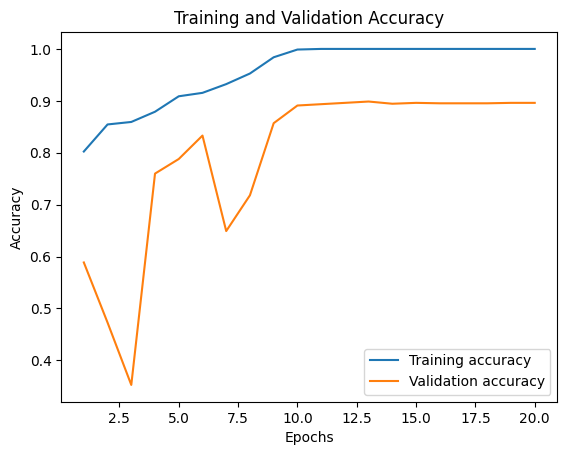

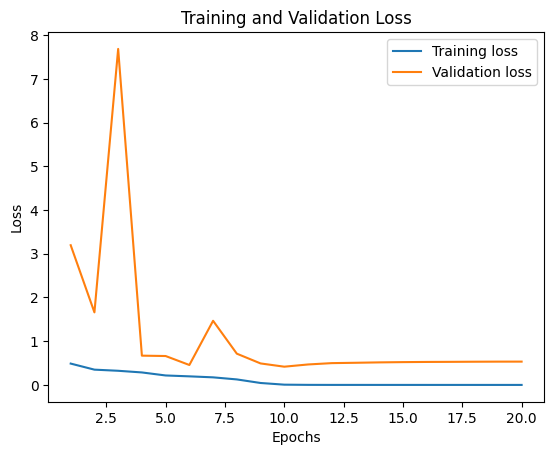

In [18]:
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
y_pred = model.predict(x_test)

44/44 [==============================] - 5s 84ms/step


In [21]:
y_test2 = y_test.flatten()
y_test2

array([0, 0, 2, ..., 0, 2, 2])

In [22]:
y_hat = np.argmax(y_pred, axis=1)
y_hat

array([3, 0, 2, ..., 0, 2, 0])

              precision    recall  f1-score   support

      normal     0.9572    0.9792    0.9681       480
       covid     0.9897    0.9897    0.9897       194
   bacterial     0.8133    0.8909    0.8503       440
       viral     0.7721    0.6194    0.6874       268

    accuracy                         0.8828      1382
   macro avg     0.8831    0.8698    0.8739      1382
weighted avg     0.8801    0.8828    0.8792      1382



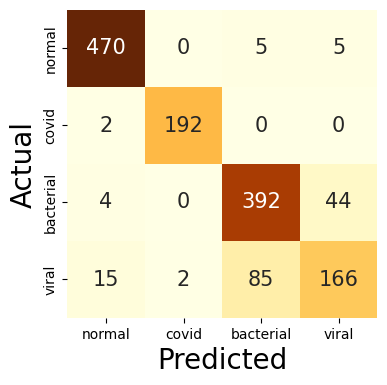

In [23]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

target_names = ['normal','covid','bacterial','viral']
report = classification_report(y_test2, y_hat, target_names=target_names, digits=4)
print(report)

disp = confusion_matrix(y_test2, y_hat)
disp.astype('int')
pd.options.display.float_format='{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size":15},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()